# Perturbation Theory

In this notebook, we compare the perturbation theory calculations with the ones from the vGH Ansatz.

In [1]:
import numpy as np
import autograd.numpy as np
from autograd import grad

import scipy
import matplotlib.pyplot as plt
import time, os, sys, gc

import h5py 

import svgutils.transform as sg 
import sys 

import matplotlib.patches as patches

from scipy.integrate import solve_ivp

import class_energy as energy
import class_equations_of_motion as eom 

import class_handle_input as h_in
import class_handle_wavefunctions as h_wavef

import class_visualization as vis
import class_mass_size as mass_size

### Self Energy expression

We compute the self-energy obtained from the perturbative Ansatz and find the energy that fulfills the self-consistent equation.

In [2]:
def integrate_self_energy(V_0, tx, ty, B, E):
    E_self = lambda kx, ky: (2*V_0**2)/(4*np.pi**2)*(1-np.cos(kx)*np.cos(ky))/(B-E-2*tx*np.cos(kx)-2*ty*np.cos(ky))
    E_self_int = scipy.integrate.dblquad(E_self, -np.pi,np.pi, -np.pi,np.pi)
    return E_self_int

def find_Ep(V_0, tx, ty, B, E_guess):
    E_self_int = lambda E: E+integrate_self_energy(V_0, tx, ty, B, E-2*tx-2*ty)[0]
    E_min = scipy.optimize.fsolve(E_self_int, [E_guess])
    return E_min

def find_first_deriv_self_energy(V_0, tx, ty, B, h):
    E_min = find_Ep(V_0, tx, ty, B, guess_Ep(V_0))

    E_self_int = lambda E: integrate_self_energy(V_0, tx, ty, B, E-2*tx-2*ty)[0].real

    x = E_min
    
    E_min_prime = (-E_self_int(x + 2*h) + 8*E_self_int(x + h) - 8*E_self_int(x - h) + E_self_int(x - 2*h)) / (12 * h)
    
    #E_self_int_prime = grad(E_self_int)

    #E_min_prime = E_self_int_prime(E_min)
    return E_min_prime
    
def guess_Ep(V_0):
    return -0.004649*V_0**2-0.07471*V_0+0.8718

Here we define functions that compute the vGH and perturbative energies for different potentials.

In [11]:
def quick_pot_scan(params, V_0_arr, folder):
    h5_io_object = h_in.io_hdf5()

    print('\nvGH Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        print('V0 =', V_0_arr[i])
        params["V_0"] = V_0_arr[i]

        eom_object = eom.eom(params=params)
        wavefunc_object = h_wavef.wavefunctions(params=params)
        wfn_manip = h_wavef.wavefunc_operations(params=params)
        ''' 
        Init wavefunction
        '''
        psi_init = wavefunc_object.create_init_wavefunction(params['init_choice'])
        psi_init = wfn_manip.reshape_one_dim(psi_init)
        ''' 
        Imaginary Time Propagation
        '''
        psi, E_evo, epsilon_evo = eom_object.solve_for_fixed_params_imag_time_prop_new(psi_init)
        E_arr[i] = E_evo[-1]

        h5_io_object.save_calculation_run(psi, E_evo, epsilon_evo, params, folder)

    return E_arr

def pert_pot_scan(params, V_0_arr):
    print('\nPerturbative Calculations:')
    E_arr = np.zeros(len(V_0_arr), dtype=complex)
    for i in range(len(V_0_arr)):
        E_min = find_Ep(V_0_arr[i], params["tx"], params["ty"], params["B"], guess_Ep(V_0_arr[i]))
        E_arr[i] = E_min[0]
        print('V0 =', V_0_arr[i], ', E =', E_arr[i])
        
    return E_arr

def get_Ep_from_E_vGH(E_vGH, tx, ty):
    return E_vGH+2*tx+2*ty

def get_E_from_Ep(E_vGH, tx, ty):
    return E_vGH-2*tx-2*ty

def get_E_arr(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]

        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E
    return E_arr

In [4]:
def calc_eff_mass(self_E_prime, V_0, tx, ty, B):
    kx = 0
    ky = 0
    
    sec_deriv_band_x = 2*tx*np.cos(kx)
    sec_deriv_band_y = 2*ty*np.cos(ky)
    
    eff_mass_x = (1+self_E_prime)/sec_deriv_band_x
    eff_mass_y = (1+self_E_prime)/sec_deriv_band_y
    return eff_mass_x, eff_mass_y

### Define the calculation parameters

In [5]:
params = {"n": 256,
"M": 36,
"Mx": 16,
"Mx_display": 4,
"converge_new_lattice": "no",
"My": 16,
"My_display": 4,
"B": 1.0,
"tx": 100,
"ty": 100,
"V_0": 150.0,
"qx": 0,
"qy": 0,
"init_choice": "uniform",
"external_wf_tag": " ",
"excitation_no": 11,
"angle_pattern": [0,0,0,0],
"V_0_pattern": [0,0,0,0],
"n_states": 0,
"path_to_input_wavefunction": " ",
"dt": 0.001,
"tol": 1e-10}

x = (2*np.pi/params["n"])*np.arange(params["n"])

''' 
I/O Object
'''
h5_io_object = h_in.io_hdf5()

### Perturbation Energies

In [6]:
V_0_range1 = np.linspace(0,10,21) 
V_0_range2 = np.linspace(15,100,18)

V_0_range = np.append(V_0_range1, V_0_range2)

In [7]:
#V_0_range = np.linspace(0,100,21)

params["B"] = 1.0
params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
Ep_pert1_B_1 = pert_pot_scan(params, V_0_range)
E_pert1_B_1 = get_E_from_Ep(Ep_pert1_B_1, params["tx"], params["ty"])

params["B"] = 200.0
Ep_pert1_B_200 = pert_pot_scan(params, V_0_range)
E_pert1_B_200 = get_E_from_Ep(Ep_pert1_B_200, params["tx"], params["ty"])



params["B"] = 1.0
params["tx"] = 50
params["ty"] = 150
Ep_pert2_B_1 = pert_pot_scan(params, V_0_range)
E_pert2_B_1 = get_E_from_Ep(Ep_pert2_B_1, params["tx"], params["ty"])

params["B"] = 200.0
Ep_pert2_B_200 = pert_pot_scan(params, V_0_range)
E_pert2_B_200 = get_E_from_Ep(Ep_pert2_B_200, params["tx"], params["ty"])



params["B"] = 1.0
params["tx"] = 10
params["ty"] = 190
Ep_pert3_B_1 = pert_pot_scan(params, V_0_range)
E_pert3_B_1 = get_E_from_Ep(Ep_pert3_B_1, params["tx"], params["ty"])

params["B"] = 200.0
params["tx"] = 10
params["ty"] = 190
Ep_pert3_B_200 = pert_pot_scan(params, V_0_range)
E_pert3_B_200 = get_E_from_Ep(Ep_pert3_B_200, params["tx"], params["ty"])


Perturbative Calculations:
V0 = 0.0 , E = 0j
V0 = 0.5 , E = (-0.0015774701930992587+0j)
V0 = 1.0 , E = (-0.00630965254400675+0j)
V0 = 1.5 , E = (-0.014195863338946384+0j)
V0 = 2.0 , E = (-0.025234966265329596+0j)
V0 = 2.5 , E = (-0.039425377132477894+0j)
V0 = 3.0 , E = (-0.05676507029911911+0j)
V0 = 3.5 , E = (-0.07725158663945983+0j)
V0 = 4.0 , E = (-0.10088204285190014+0j)
V0 = 4.5 , E = (-0.12765314189619664+0j)
V0 = 5.0 , E = (-0.15756118433857913+0j)
V0 = 5.5 , E = (-0.19060208038760648+0j)
V0 = 6.0 , E = (-0.2267713624153777+0j)
V0 = 6.5 , E = (-0.2660641977765987+0j)
V0 = 7.0 , E = (-0.30847540176007604+0j)
V0 = 7.5 , E = (-0.3539994505313079+0j)
V0 = 8.0 , E = (-0.40263049394941136+0j)
V0 = 8.5 , E = (-0.4543623681651993+0j)
V0 = 9.0 , E = (-0.5091886079289124+0j)
V0 = 9.5 , E = (-0.5671024585554438+0j)
V0 = 10.0 , E = (-0.6280968875135562+0j)
V0 = 15.0 , E = (-1.4057483402862088+0j)
V0 = 20.0 , E = (-2.4820391863270785+0j)
V0 = 25.0 , E = (-3.84675875098263+0j)
V0 = 30.0 , E 

### vGH energies

#### Note: for big lattices, it is better to use the stand-alone python script! This cell is just suited for quick computations

In [6]:
V_0_range = np.linspace(0,100,21)

params["B"] = 1.0
params["tx"] = 100
params["ty"] = 100
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 10.0
E_vGH1_B_10 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 1.0
params["tx"] = 50
params["ty"] = 150
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2 = quick_pot_scan(params, V_0_range, folder)

params["B"] = 1.0
params["tx"] = 10
params["ty"] = 190
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3 = quick_pot_scan(params, V_0_range, folder)



vGH Calculations:
V0 = 0.0
V0 = 5.0


KeyboardInterrupt: 

Read in the vGH calculations from the wavefunctions.

In [12]:
check_sys = 'tx_100_ty_100'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_100_ty_100/'
E_vGH1_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)



check_sys = 'tx_50_ty_150'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_50_ty_150'
check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_50_ty_150/'
E_vGH2_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)



check_sys = 'tx_10_ty_190'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3_B_1 = get_E_arr(V_0_range, folder, check_sys, check_sym)

check_sys = 'tx_10_ty_190'
check_sym = '_B_200.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])
folder = 'results/perturbation_theory/tx_10_ty_190/'
E_vGH3_B_200 = get_E_arr(V_0_range, folder, check_sys, check_sym)

## Plot the results to show how the energies match!

In [13]:
def E_to_plot(E, t):
    return np.abs(E+2*t)/t

In [14]:
E_pert1_B_1-(E_vGH1_B_1-0.0017)

array([1.70000000e-03+0.00000000e+00j, 1.62953143e-03-1.15970147e-22j,
       1.51684673e-03+7.19272057e-23j, 1.40070609e-03+1.35760839e-21j,
       1.27309034e-03-1.08882507e-21j, 1.13061944e-03+1.72680690e-21j,
       9.92420010e-04-2.06627959e-21j, 8.62822612e-04-3.00031728e-21j,
       7.45526220e-04-2.84096998e-21j, 6.14836119e-04-3.28068891e-21j,
       5.31569193e-04+1.68450397e-20j, 4.39474602e-04+5.15299513e-21j,
       3.72440273e-04+1.22189561e-20j, 3.35381634e-04-1.41846095e-20j,
       3.33430324e-04+2.40002789e-20j, 3.71967393e-04-2.93923843e-20j,
       4.18401283e-04+1.73428884e-20j, 5.54934596e-04+4.10178094e-20j,
       7.10007753e-04+8.74342821e-22j, 9.70277443e-04-3.18552304e-20j,
       1.26161722e-03-3.35657291e-20j, 9.87081910e-03+7.51122115e-20j,
       3.51860375e-02+1.00405574e-19j, 8.80276886e-02-3.01610792e-19j,
       1.80600001e-01+1.80267057e-19j, 3.26022252e-01+2.98910340e-19j,
       5.37941954e-01-7.52928435e-19j, 8.30335880e-01-8.72971367e-19j,
      

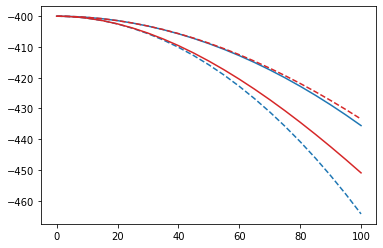

In [15]:
plt.plot(V_0_range, E_vGH1_B_1.real, color='tab:blue', linestyle='dashed')
plt.plot(V_0_range, E_vGH1_B_200.real, color='tab:blue')
plt.plot(V_0_range, E_pert1_B_1.real, color='tab:red')
plt.plot(V_0_range, E_pert1_B_200.real, color='tab:red', linestyle='dashed')
#plt.plot(V_0_range, E_pert3.real, color='tab:red')
#plt.plot(V_0_range, E_vGH3.real, color='tab:blue')

#plt.xscale('log')
#plt.yscale('log')

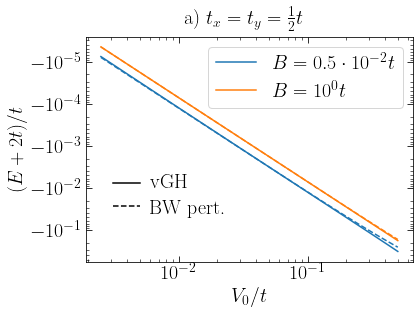

In [16]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'a) $t_x=t_y=\frac{1}{2}t$', fontsize=font_size)

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH1_B_1.real,t)[1:], color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert1_B_1.real,t)[1:], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH1_B_200.real,t)[1:], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert1_B_200.real,t)[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=font_size, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)

plt.savefig('results/perturbation_theory/B_comp_tx_100_ty_100.svg', bbox_inches='tight')

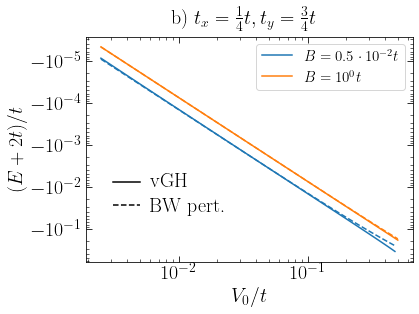

In [17]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'b) $t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$', fontsize=font_size)

axs.plot(V_0_range[1:len(E_vGH2_B_1)-1]/t, E_to_plot(E_vGH2_B_1.real[1:len(E_vGH2_B_1)-1],t), color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:len(E_vGH2_B_1)-1]/t, E_to_plot(E_pert2_B_1.real[1:len(E_vGH2_B_1)-1],t), color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:]/t, E_to_plot(E_vGH2_B_200.real,t)[1:], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:]/t, E_to_plot(E_pert2_B_200.real,t)[1:], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/B_comp_tx_50_ty_100.svg', bbox_inches='tight')

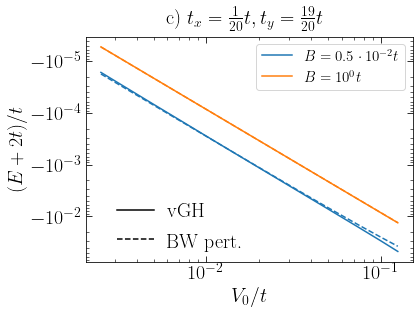

In [18]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'c) $t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_1.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$B = 0.5\cdot 10^{-2} t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_1.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_200.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$B = 10^0 t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_200.real,t)[1:24], color='tab:orange', linestyle='dashed')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/B_comp_tx_10_ty_190.svg', bbox_inches='tight')

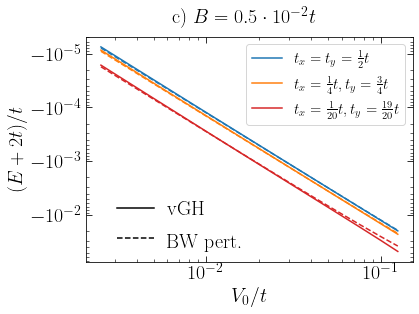

In [19]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'c) $B = 0.5\cdot 10^{-2}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH1_B_1.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$t_x=t_y=\frac{1}{2}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert1_B_1.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH2_B_1.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert2_B_1.real,t)[1:24], color='tab:orange', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_1.real,t)[1:24], color='tab:red', linestyle='solid', label=r'$t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_1.real,t)[1:24], color='tab:red', linestyle='dashed')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)


plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.75e-2*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.27e-1*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-2), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-1), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/sym_comp_B_0.01t.svg', bbox_inches='tight')

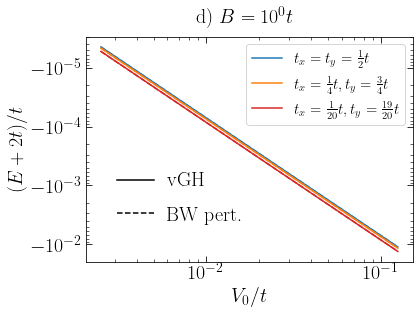

In [20]:
A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.suptitle(r'd) $B = 10^{0}t$', fontsize=font_size)

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH1_B_200.real,t)[1:24], color='tab:blue', linestyle='solid', label=r'$t_x=t_y=\frac{1}{2}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert1_B_200.real,t)[1:24], color='tab:blue', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH2_B_200.real,t)[1:24], color='tab:orange', linestyle='solid', label=r'$t_x=\frac{1}{4}t,t_y=\frac{3}{4}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert2_B_200.real,t)[1:24], color='tab:orange', linestyle='dashed')

axs.plot(V_0_range[1:24]/t, E_to_plot(E_vGH3_B_200.real,t)[1:24], color='tab:red', linestyle='solid', label=r'$t_x=\frac{1}{20}t,t_y=\frac{19}{20}t$')
axs.plot(V_0_range[1:24]/t, E_to_plot(E_pert3_B_200.real,t)[1:24], color='tab:red', linestyle='dashed')


plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$(E+2t)/t$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.invert_yaxis()
axs.set_yticks([1e-1,1e-2,1e-3,1e-4,1e-5],[r'$-10^{-1}$',r'$-10^{-2}$',r'$-10^{-3}$',r'$-10^{-4}$',r'$-10^{-5}$'], fontsize=font_size)

axs.plot(np.linspace(3.1e-3,5e-3,100), 0.8e-3*np.ones(100), linestyle='solid', color='black')
axs.plot(np.linspace(3.1e-3,5e-3,100), 0.3e-2*np.ones(100), linestyle='dashed', color='black')

axs.annotate('vGH', xy=(0.6*1e-2,1e-3), fontsize=font_size)
axs.annotate('BW pert.', xy=(0.6*1e-2,0.4e-2), fontsize=font_size)

axs.legend(fontsize=15, loc=1)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/sym_comp_B_t.svg', bbox_inches='tight')

In [21]:
plt.plot(V_0_range/t, E_to_plot(E_pert1.real,t), marker='x', color='tab:blue', linestyle='solid', label=r'$t_x = 100, t_y = 100$')
plt.plot(V_0_range/t, E_to_plot(E_vGH1.real,t), marker='x', color='tab:blue', linestyle='dashed')
plt.plot(V_0_range/t, (1/(1*(1+4*t))**0.5)*V_0_range**2/t, marker='x', color='tab:green', linestyle='dashed')


plt.xscale('log')
plt.yscale('log')

NameError: name 'E_pert1' is not defined

In [ ]:
plt.plot(V_0_range/t, 2*(0.5*(1/(1*(1+4*200))**0.5)*(V_0_range)**2)/t, marker='x', color='tab:green', linestyle='dashed')
plt.plot(V_0_range/t, (0.5*(1/(1*(1+4*200))**0.5)*(V_0_range)**2)/t, marker='x', color='tab:green', linestyle='dashed')

plt.xscale('log')
plt.yscale('log')

In [ ]:
V_0_range = np.linspace(0,10,3)

params["tol"] = 1e-8

params["tx"] = 100
params["ty"] = 100
t = params["tx"] + params["ty"]
E_pert1, E_vGH1 = get_energies(params,V_0_range)

print(E_pert1-E_vGH1)

### Effective Mass Calculations

In [22]:
def eff_mass_V_0_range(V_0_eff_mass_range, params):
    h = 1e-3
    
    eff_mass_x_arr = np.zeros(len(V_0_eff_mass_range))
    eff_mass_y_arr = np.zeros(len(V_0_eff_mass_range))
    for i in range(len(V_0_eff_mass_range)):
        V_0 = V_0_eff_mass_range[i]
    
        self_E_prime = find_first_deriv_self_energy(V_0, params["tx"], params["ty"], params["B"], h)
        eff_mass_x, eff_mass_y = calc_eff_mass(self_E_prime, V_0, params["tx"], params["ty"], params["B"])

        eff_mass_x_arr[i] = eff_mass_x
        eff_mass_y_arr[i] = eff_mass_y
        
        print('V_0,eff_mass =', V_0, eff_mass_x, eff_mass_y)
    return eff_mass_x_arr, eff_mass_y_arr

In [23]:
V_0_range1 = np.linspace(0,10,21) 
V_0_range2 = np.linspace(15,100,18)

V_0_eff_mass_range = np.append(V_0_range1, V_0_range2)

params["B"] = 1
params["tx"] = 100
params["ty"] = 100 
print('Eff Mass cal for B = ', params["B"], ':\n')
eff_mass1_x_B_2, eff_mass1_y_B_2 = eff_mass_V_0_range(V_0_eff_mass_range, params)

params["B"] = 200
params["tx"] = 100
params["ty"] = 100
print('\nEff Mass cal for B = ', params["B"], ':\n')
eff_mass1_x_B_200, eff_mass1_y_B_200 = eff_mass_V_0_range(V_0_eff_mass_range, params)

Eff Mass cal for B =  1 :

V_0,eff_mass = 0.0 0.005 0.005
V_0,eff_mass = 0.5 0.0050000603098099335 0.0050000603098099335
V_0,eff_mass = 1.0 0.005000241050740959 0.005000241050740959
V_0,eff_mass = 1.5 0.005000541661760851 0.005000541661760851
V_0,eff_mass = 2.0 0.005000961222433896 0.005000961222433896
V_0,eff_mass = 2.5 0.005001498473964701 0.005001498473964701
V_0,eff_mass = 3.0 0.005002151846990973 0.005002151846990973
V_0,eff_mass = 3.5 0.005002919494654698 0.005002919494654698
V_0,eff_mass = 4.0 0.005003799329301481 0.005003799329301481
V_0,eff_mass = 4.5 0.0050047890611714255 0.0050047890611714255
V_0,eff_mass = 5.0 0.0050058862374810454 0.0050058862374810454
V_0,eff_mass = 5.5 0.005007088280525025 0.005007088280525025
V_0,eff_mass = 6.0 0.005008392523669111 0.005008392523669111
V_0,eff_mass = 6.5 0.005009796244379925 0.005009796244379925
V_0,eff_mass = 7.0 0.0050112966937389215 0.0050112966937389215
V_0,eff_mass = 7.5 0.0050128911221196115 0.0050128911221196115
V_0,eff_mass = 8.

In [25]:
def get_E_arr_eff_mass(V_0_range, folder, check_sys, check_sym):
    h5_io_object = h_in.io_hdf5()
    
    E_arr = np.zeros(len(V_0_range), dtype=complex)
    for i in range(len(V_0_range)):
        check_sys_n = check_sys+'_V0_'+str(V_0_range[i])+'_'
        file_list = [f for f in os.listdir(folder) if check_sys_n in f and check_sym in f]

        if len(file_list) > 1: 
            break
        for file in file_list:
            file_name = folder+file
            psi, params = h5_io_object.get_psi(file_name)

            print(params["V_0"])
            energy_object = energy.energy(params=params)
            E, E_T, E_B, E_V = energy_object.calc_energy(psi)
            E_arr[i] = E

            print(params["V_0"], E_arr[i])
    return E_arr

In [26]:
V_eff_mass_vGH = np.array([1,10,60])

params["Mx"] = 64
params["My"] = 64

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])+'_qx_0_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH1_q0 = get_E_arr_eff_mass(V_eff_mass_vGH, folder, check_sys, check_sym)

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])+'_qx_1_qy_0'
folder = 'results/eff_mass/fo/'
E_vGH1_qx = get_E_arr_eff_mass(V_eff_mass_vGH, folder, check_sys, check_sym)

check_sys = 'tx_100.0_ty_100.0'
check_sym = '_B_1.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])+'_qx_0_qy_1'
folder = 'results/eff_mass/fo/'
E_vGH1_qy = get_E_arr_eff_mass(V_eff_mass_vGH, folder, check_sys, check_sym)

print(E_vGH1_q0)
print(E_vGH1_qx)
print(E_vGH1_qy)
print(E_vGH1_qx-E_vGH1_q0)
print(E_vGH1_qy-E_vGH1_qx)

1.0
1.0 (-400.0061264991561-4.0893666030347074e-22j)
10.0
10.0 (-400.62803907826674-5.7566948287553384e-21j)
60.0
60.0 (-422.8649458147167-3.183394459739971e-18j)
1.0
1.0 (-399.0431198146087+4.163311572696595e-15j)
10.0
10.0 (-399.6713434461168+9.712737460184792e-15j)
60.0
60.0 (-422.13461386413377-2.837706576051827e-15j)
1.0
1.0 (-399.0431198146251-5.551199626883568e-15j)
10.0
10.0 (-399.67134344610866-1.3840169919335723e-15j)
60.0
60.0 (-422.13461386414167+1.3828020702819469e-14j)
[-400.0061265 -4.08936660e-22j -400.62803908-5.75669483e-21j
 -422.86494581-3.18339446e-18j]
[-399.04311981+4.16331157e-15j -399.67134345+9.71273746e-15j
 -422.13461386-2.83770658e-15j]
[-399.04311981-5.55119963e-15j -399.67134345-1.38401699e-15j
 -422.13461386+1.38280207e-14j]
[0.96300668+4.16331198e-15j 0.95669563+9.71274322e-15j
 0.73033195-2.83452318e-15j]
[-1.63709046e-11-9.71451120e-15j  8.12860890e-12-1.10967545e-14j
 -7.90123522e-12+1.66657273e-14j]


[0.00500427 0.00503728 0.00659856]
[  0.    0.5   1.    1.5   2.    2.5   3.    3.5   4.    4.5   5.    5.5
   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   15.   20.   25.
  30.   35.   40.   45.   50.   55.   60.   65.   70.   75.   80.   85.
  90.   95.  100. ] [0.005      0.00500006 0.00500024 0.00500054 0.00500096 0.0050015
 0.00500215 0.00500292 0.0050038  0.00500479 0.00500589 0.00500709
 0.00500839 0.0050098  0.0050113  0.00501289 0.00501458 0.00501635
 0.00501821 0.00502015 0.00502218 0.00504638 0.0050765  0.0051112
 0.00514952 0.00519073 0.00523426 0.00527963 0.00532646 0.0053744
 0.00542317 0.00547255 0.00552231 0.00557228 0.00562231 0.00567226
 0.00572203 0.00577152 0.00582065]
1.0 0.005000241050740959


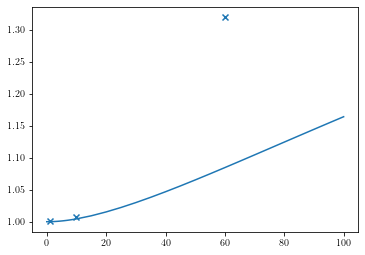

In [27]:
eff_mass_x_vGH = (2*(E_vGH1_qx-E_vGH1_q0)/(2*np.pi/64)**2)**(-1)
print(eff_mass_x_vGH.real)
print(V_0_eff_mass_range,eff_mass1_x_B_2)
print(V_0_eff_mass_range[2],eff_mass1_x_B_2[2])
plt.scatter(V_eff_mass_vGH, eff_mass_x_vGH.real/0.005, marker='x')
plt.plot(V_0_eff_mass_range,eff_mass1_x_B_2/0.005)
#plt.scatter(V_eff_mass_vGH/t, eff_mass_to_plot(eff_mass_x_vGH.real, eff_mass_x_0), marker='x')


In [28]:
def eff_mass_to_plot(eff_mass, eff_mass_0):
    return eff_mass/eff_mass_0 - 1

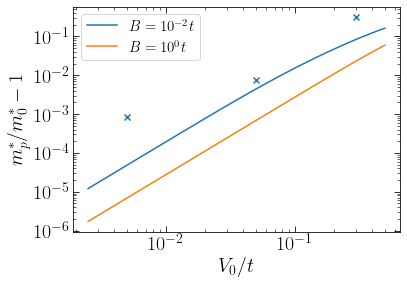

In [29]:
tx = 100
ty = 100

t = tx+ty

eff_mass_x_0 = 1/(2*tx)
eff_mass_y_0 = 1/(2*ty)

A = 6
plt.rc('figure', figsize=[46.82 * .5**(.5 * A), 33.11 * .5**(.5 * A)])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font_size = 20

fig, axs = plt.subplots()

plt.plot(V_0_eff_mass_range[1:]/t, eff_mass_to_plot(eff_mass1_x_B_2, eff_mass_x_0)[1:], label=r'$B = 10^{-2}t$')
plt.plot(V_0_eff_mass_range[1:]/t, eff_mass_to_plot(eff_mass1_x_B_200, eff_mass_y_0)[1:], label=r'$B = 10^{0}t$')

plt.scatter(V_eff_mass_vGH/t, eff_mass_to_plot(eff_mass_x_vGH.real, eff_mass_x_0), marker='x')

plt.xlabel(r'$V_0/t$', fontsize=font_size)
plt.ylabel(r'$m^*_p/m^*_0 - 1$', fontsize=font_size)

plt.xticks(fontsize=font_size)
plt.yticks(fontsize=font_size)

axs.set_xscale('log', base=10)
axs.set_yscale('log', base=10)

axs.legend(fontsize=15, loc=2)

plt.tick_params(axis='x', direction='in', length=6, top=True)
plt.tick_params(axis='y', direction='in', length=6, right=True)
plt.tick_params(axis='x', which='minor', direction='in', length=3, top=True)
plt.tick_params(axis='y', which='minor', direction='in', length=3, right=True)

plt.tick_params(which='minor', axis='y', direction='in', right=True)
plt.savefig('results/perturbation_theory/pert_eff_mass_tx_100_ty_100.svg', bbox_inches='tight')

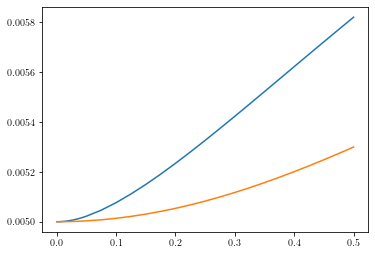

In [30]:
plt.plot(V_0_eff_mass_range/t, eff_mass1_x_B_2)
plt.plot(V_0_eff_mass_range/t, eff_mass1_x_B_200)

### Effective 1D Ferro-Domain Energies

In [41]:
V_eff_1D = np.array([0.0,30.0,60.0,90.0,120.0,150.0,180.0])

params["Mx"] = 2
params["My"] = 256

check_sys = 'tx_0_ty_100'
check_sym = '_B_2.0_Mx_'+str(params["Mx"])+'_My_'+str(params["My"])+'_qx_0_qy_0'
folder = 'results/perturbation_theory/tx_0_ty_100/'
E_vGH1_eff1D = get_E_arr_eff_mass(V_eff_1D, folder, check_sys, check_sym)

print(E_vGH1_eff1D)

0.0
0.0 (-199.9490495222992+4.6041473002488965e-21j)
30.0
30.0 (-241.68278079222767-2.0604865565428353e-17j)
60.0
60.0 (-312.9409968856357-4.968691091309337e-18j)
90.0
90.0 (-392.7950884960017-6.801773022522007e-17j)
120.0
120.0 (-477.8098573455151-1.03577770268719e-16j)
150.0
150.0 (-567.10643044566+8.259896478294658e-17j)
180.0
180.0 (-660.9352966309253+3.039334287456375e-17j)
[-199.94904952+4.60414730e-21j -241.68278079-2.06048656e-17j
 -312.94099689-4.96869109e-18j -392.7950885 -6.80177302e-17j
 -477.80985735-1.03577770e-16j -567.10643045+8.25989648e-17j
 -660.93529663+3.03933429e-17j]


In [32]:
V_0_range1 = np.linspace(0,10,21) 
V_0_range2 = np.linspace(15,100,18)

V_0_range_eff_1D = np.linspace(0,200,21) #np.append(V_0_range1, V_0_range2)

In [54]:
params["B"] = 2.0
params["tx"] = 0.0
params["ty"] = 100.0
t = params["tx"] + params["ty"]
Ep_pert_eff_1D_v1_B_2 = pert_pot_scan(params, V_0_range_eff_1D)
E_pert1_eff_1D_v1_B_2 = get_E_from_Ep(Ep_pert_eff_1D_v1_B_2, params["tx"], params["ty"])


Perturbative Calculations:
V0 = 0.0 , E = 0j
V0 = 10.0 , E = (-4.038928849035286+0j)
V0 = 20.0 , E = (-10.942843094581699+0j)
V0 = 30.0 , E = (-19.09717680756454+0j)
V0 = 40.0 , E = (-28.11621588676885+0j)
V0 = 50.0 , E = (-37.79478535608321+0j)
V0 = 60.0 , E = (-47.99999999999999+0j)
V0 = 70.0 , E = (-58.6375297292653+0j)
V0 = 80.0 , E = (-69.63672114009384+0j)
V0 = 90.0 , E = (-80.94275220818233+0j)
V0 = 100.0 , E = (-92.51200424102154+0j)
V0 = 110.0 , E = (-104.30911212351313+0j)
V0 = 120.0 , E = (-116.30497544930594+0j)
V0 = 130.0 , E = (-128.4753594461188+0j)
V0 = 140.0 , E = (-140.7998779262876+0j)
V0 = 150.0 , E = (-153.26123443818352+0j)
V0 = 160.0 , E = (-165.84464400489216+0j)
V0 = 170.0 , E = (-178.53738474576758+0j)
V0 = 180.0 , E = (-191.3284450982931+0j)
V0 = 190.0 , E = (-204.20824278315393+0j)
V0 = 200.0 , E = (-217.16839850141278+0j)


In [99]:
def E_fd_analytic(V_0, B, t):
    return -2*V_0**2/(np.sqrt(B*(B+4*t)))

def find_Ep_eff_1D(V_0, t, B):
    Ep_implicit = lambda Ep: Ep+2*V_0**2/np.sqrt((B+2*t-Ep)**2 - 4*t**2)
    Ep_min = scipy.optimize.fsolve(Ep_implicit, [guess_Ep_eff_1D(V_0)])
    return Ep_min
    
def guess_Ep_eff_1D(V_0):
    return -0.004649*V_0**2-0.07471*V_0+0.8718

In [100]:
Ep_eff_1D_test = find_Ep_eff_1D(V_0_range_eff_1D, 100, 2)
E_eff_1D_test = get_E_from_Ep(Ep_eff_1D_test, 0, 200)

print(V_eff_1D, E_vGH1_eff1D+2*100)
print(V_0_range_eff_1D, Ep_eff_1D_test)
print(V_0_range_eff_1D, Ep_pert_eff_1D_v1_B_2)

print(Ep_pert_eff_1D_v1_B_2 - Ep_eff_1D_test)

[  0.  30.  60.  90. 120. 150. 180.] [ 5.09504777e-02+4.60414730e-21j -4.16827808e+01-2.06048656e-17j
 -1.12940997e+02-4.96869109e-18j -1.92795088e+02-6.80177302e-17j
 -2.77809857e+02-1.03577770e-16j -3.67106430e+02+8.25989648e-17j
 -4.60935297e+02+3.03933429e-17j]
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200.] [-2.06986803e-21 -4.03892883e+00 -1.09428429e+01 -1.90971768e+01
 -2.81162163e+01 -3.77947850e+01 -4.79999999e+01 -5.86375299e+01
 -6.96367213e+01 -8.09427522e+01 -9.25120042e+01 -1.04309112e+02
 -1.16304975e+02 -1.28475359e+02 -1.40799878e+02 -1.53261234e+02
 -1.65844644e+02 -1.78537385e+02 -1.91328445e+02 -2.04208243e+02
 -2.17168399e+02]
[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180. 190. 200.] [   0.        +0.j   -4.03892885+0.j  -10.94284309+0.j  -19.09717681+0.j
  -28.11621589+0.j  -37.79478536+0.j  -48.        +0.j  -58.63752973+0.j
  -69.63672114+0.j  -80.94275

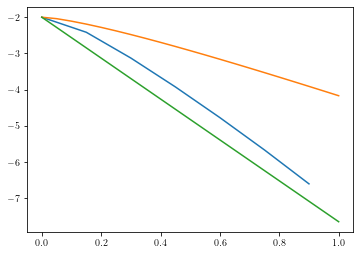

In [124]:
fig, axs = plt.subplots()

plt.plot(V_eff_1D/200, E_vGH1_eff1D.real/100)
plt.plot(V_0_range_eff_1D/200, -2+Ep_eff_1D_test/100)
plt.plot(V_0_range_eff_1D/200, -2-2*2**0.5*V_0_range_eff_1D/100)
#plt.plot(V_0_range/100, -E_to_plot(E_pert1_B_1.real, 100))
#plt.plot(V_0_range_eff_1D/200, -E_to_plot(E_eff_1D_test.real, 100))

#plt.xscale('log', base=10)
#plt.yscale('log', base=10)

#axs.invert_yaxis()

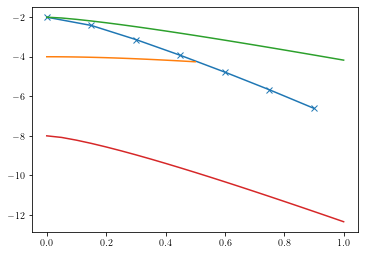

In [121]:
fig, axs = plt.subplots()

plt.plot(V_eff_1D/200, E_vGH1_eff1D.real/100, marker='x')
plt.plot(V_0_range/200, -2+E_pert1_B_1.real/200)
plt.plot(V_0_range_eff_1D/200, E_pert1_eff_1D_v1_B_2.real/100)
#plt.plot(V_0_range_eff_1D/200, E_fd_analytic(V_0_range_eff_1D, 1, 100)/200-2)
#plt.plot(V_0_range_eff_1D/200, (-2*100-np.sqrt(2)*V_0_range_eff_1D)/100)

plt.plot(V_0_range_eff_1D/200, E_eff_1D_test/50)

#plt.xscale('log', base=10)
#plt.yscale('log', base=10)

#axs.invert_yaxis()

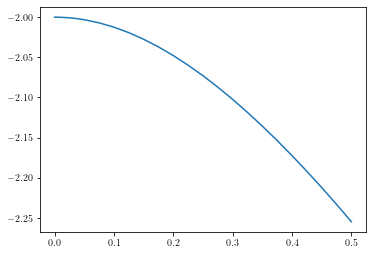

In [178]:
plt.plot(V_0_range/200, E_pert1_B_1.real/100)